# Bayesian Experimental Design for model selection

Script used to perform optimisation where a 6 step experiment is being design considering the average of the Bhattacharyya distances of RFP and GFP for the two models

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from numba import jit
import gaussianprocess as gp
from fitderiv import fitderiv
import genutils as gu
import datetime
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math


### Model 1 Functions (ODEs, Steady State and Event based representation)
* Lugagne et. al. Model

In [2]:
@jit
def model1(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    
    if u_IPTG > y[0]:
        dInd_dt[0]=k_in_IPTG*(u_IPTG-y[0])
    else:
        dInd_dt[0]=k_out_IPTG*(u_IPTG-y[0])
    
    if u_aTc > y[2]:
        dInd_dt[1]=k_in_aTc*(u_aTc-y[1])
    else:
        dInd_dt[1]=k_out_aTc*(u_aTc-y[1])
    
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState1(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode1(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState1(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model1,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 2 Functions (ODEs, Steady State and Event based representation)
* Intermediate Model (Single rate, no degradation)

In [3]:
@jit
def model2(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0]);
    dInd_dt[1] = k_aTc*(u_aTc-y[1]);
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState2(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode2(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState2(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model2,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 3 Functions (ODEs, Steady State and Event based representation)
* Lucia's Model

In [4]:
@jit
def model3(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0])-0.0165*y[0];
    dInd_dt[1] = k_aTc*(u_aTc-y[1])-0.0165*y[1];
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState3(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(4)
    alpha[0] = (k_IPTG*u_IPTG)/(k_IPTG+0.0165)
    alpha[1] = (k_aTc*u_aTc)/(k_aTc+0.0165)
    alpha[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(alpha[1]/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(alpha[0]/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode3(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    
    y_al = SteadyState3(p,ivss) # Calculation of initial guesses for steady state
    
    ssv = odeint(model3,y_al,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]
        
        
        
    
    return(final)

### Functions to simulate the 3 models for all parameter draws

In [5]:
def solveALL (ts, pD, sp, inputs, ivss, pre, model):
    
    AllSol = np.empty((len(ts),len(pD[:,1])*2))
    AllSolTest = np.empty(((round(len(ts)/5)+1),len(pD[:,1])*2))
    for drawInd in range(0,len(pD[:,1])):
        
        p = pD[drawInd,:]
        if model == 'M1':
            temp = solve_coupled_ode1(ts, p, sp, inputs, ivss, pre)
        elif model == 'M2':
            temp = solve_coupled_ode2(ts, p, sp, inputs, ivss, pre)
        elif model == 'M3':
            temp = solve_coupled_ode3(ts, p, sp, inputs, ivss, pre)
        else:
            print('Please, select a correct model as M1, M2 or M3 for the desired one')

        AllSolTest[:,drawInd] = temp[:,2][::5]
        AllSolTest[:,drawInd+(len(pD[:,1]))] = temp[:,3][::5]

    return(AllSolTest)
    

### Example:

In [10]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
t = np.linspace(0,(24*60),(24*60)+1)
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

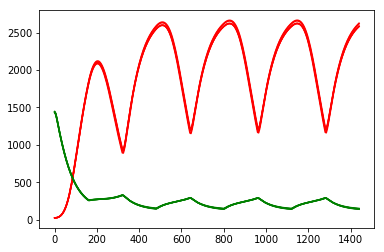

In [15]:
p = pM3[0:5,:]
test = solveALL(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Bhattacharyya distance function:

In [6]:

def BhattacharyyaDist (mu1, mu2, sd1, sd2):
    E = (sd1+sd2)/2
    Em1 = np.linalg.inv(E)
    dE = abs(np.linalg.det(E))

    t1 = np.matrix.transpose((np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))))
    t2 = np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))
    
    ft = (1/8)*t1*Em1*t2
    st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))
    
    bhd = ft+0.5*np.log(st)
    
    return(float(bhd))



### Definition of the utility function:

In [7]:

def utility2 (IPTG1, IPTG2, IPTG3, IPTG4, IPTG5, IPTG6,
             aTc1, aTc2, aTc3, aTc4, aTc5, aTc6):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7,
              round(IPTG3,2)+1e-7, int(aTc3)+1e-7, round(IPTG4,2)+1e-7, int(aTc4)+1e-7,
              round(IPTG5,2)+1e-7, int(aTc5)+1e-7, round(IPTG6,2)+1e-7, int(aTc6)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),7))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR+bdG)/2

    return(u_B)
    


### Bayesian Optimisation: 

In [8]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1), 'IPTG3': (0, 1), 'IPTG4': (0, 1),
           'IPTG5': (0, 1), 'IPTG6': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100), 'aTc3': (0, 100), 'aTc4': (0, 100), 
           'aTc5': (0, 100), 'aTc6': (0, 100)}


Setting Bayesian Optimisation with our utility function

In [9]:
optimizer3 = BayesianOptimization(
    f=utility2,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [22]:
optimizer3.maximize(
    init_points=0,
    n_iter=200,
    alpha=1e-2,
    n_restarts_optimizer=3, 
#     acq="ei", 
#     xi=1e-4
)

|   iter    |  target   |   IPTG1   |   IPTG2   |   IPTG3   |   IPTG4   |   IPTG5   |   IPTG6   |   aTc1    |   aTc2    |   aTc3    |   aTc4    |   aTc5    |   aTc6    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  805      |  2.941e+0 |  0.1305   |  0.1525   |  0.3888   |  0.7806   |  0.07898  |  0.009945 |  21.26    |  18.3     |  19.97    |  18.98    |  26.03    |  24.88    |
|  806      |  1.306e+0 |  0.5267   |  0.868    |  0.8526   |  0.1475   |  0.8568   |  0.4317   |  22.77    |  17.3     |  29.22    |  10.75    |  24.99    |  25.21    |
|  807      |  9.47e+03 |  0.9954   |  0.9381   |  0.9073   |  0.08126  |  0.1695   |  0.02367  |  22.47    |  23.46    |  24.48    |  19.88    |  22.68    |  19.33    |
|  808      |  1.313e+0 |  0.5526   |  0.4947   |  0.1339   |  0.8058   |  0.007818 |  0.2209   |  35.05    |  21.17    |  12.34    |  25.75    |  27.

|  817      |  1.704e+0 |  0.4733   |  0.2657   |  0.5564   |  0.06215  |  0.5069   |  0.3183   |  30.16    |  18.44    |  16.96    |  19.14    |  27.23    |  23.55    |
|  818      |  1.231e+0 |  0.5897   |  0.293    |  0.2428   |  0.08014  |  0.05701  |  0.7978   |  31.92    |  18.85    |  23.28    |  4.921    |  16.95    |  21.64    |
|  819      |  1.872e+0 |  0.2773   |  0.2786   |  0.09021  |  0.8877   |  0.6406   |  0.7768   |  21.49    |  12.76    |  22.7     |  20.38    |  28.37    |  27.82    |
|  820      |  1.319e+0 |  0.643    |  0.1281   |  0.6878   |  0.2896   |  0.4598   |  0.07006  |  32.34    |  21.58    |  23.58    |  13.02    |  18.59    |  18.6     |
|  821      |  3.937e+0 |  0.558    |  0.2357   |  0.3775   |  0.6277   |  0.6562   |  0.1663   |  17.65    |  12.18    |  23.36    |  25.71    |  23.12    |  19.35    |
|  822      |  2.764e+0 |  0.006104 |  0.08117  |  0.5818   |  0.6399   |  0.78     |  0.0586   |  32.17    |  22.25    |  16.94    |  15.48    |  12.

|  830      |  2.803e+0 |  0.7006   |  0.9204   |  0.8266   |  0.08642  |  0.9517   |  0.2494   |  31.73    |  25.06    |  24.62    |  13.07    |  24.27    |  3.417    |
|  831      |  3.073e+0 |  0.9241   |  0.2376   |  0.02249  |  0.02618  |  0.09621  |  0.2143   |  33.09    |  16.65    |  19.15    |  20.25    |  21.81    |  13.49    |
|  832      |  4.663e+0 |  0.4299   |  0.9756   |  0.4595   |  0.1526   |  0.3495   |  0.3869   |  25.2     |  9.25     |  24.32    |  20.28    |  28.47    |  24.67    |
|  833      |  8.621e+0 |  0.6916   |  0.2311   |  0.4697   |  0.7538   |  0.3885   |  0.04564  |  6.095    |  20.64    |  19.99    |  27.61    |  23.18    |  10.31    |
|  834      |  3.756e+0 |  0.2156   |  0.3801   |  0.09714  |  0.1634   |  0.5023   |  0.2918   |  29.23    |  23.07    |  17.56    |  14.11    |  29.3     |  27.8     |
|  835      |  1.78e+04 |  0.1047   |  0.7967   |  0.9968   |  0.02737  |  0.2312   |  0.758    |  23.86    |  22.76    |  18.03    |  19.44    |  11.

|  843      |  1.555e+0 |  0.6018   |  0.008289 |  0.7065   |  0.8609   |  0.1287   |  0.9536   |  7.278    |  24.45    |  16.88    |  18.56    |  8.544    |  6.286    |
|  844      |  1.177e+0 |  0.9459   |  0.3093   |  0.9971   |  0.3297   |  0.5151   |  0.01692  |  34.19    |  33.23    |  31.2     |  30.97    |  24.43    |  16.6     |
|  845      |  5.95e+03 |  0.9686   |  0.1619   |  0.7187   |  0.9966   |  0.7471   |  0.1813   |  25.55    |  14.37    |  26.61    |  13.32    |  22.72    |  17.55    |
|  846      |  1.35e+04 |  0.3943   |  0.672    |  0.2766   |  0.9294   |  0.3117   |  0.4727   |  33.01    |  21.12    |  23.01    |  14.19    |  15.16    |  17.06    |
|  847      |  3.947e+0 |  0.119    |  0.5181   |  0.01267  |  0.7526   |  0.9325   |  0.9519   |  15.0     |  19.17    |  31.49    |  11.0     |  8.826    |  15.93    |
|  848      |  1.768e+0 |  0.0495   |  0.5648   |  0.9475   |  0.6463   |  0.1938   |  0.1139   |  30.1     |  22.73    |  31.44    |  15.8     |  18.

|  856      |  4.148e+0 |  0.8922   |  0.4828   |  0.961    |  0.766    |  0.3777   |  0.2828   |  31.33    |  24.33    |  23.13    |  18.03    |  26.49    |  15.66    |
|  857      |  1.122e+0 |  0.208    |  0.4466   |  0.8089   |  0.1496   |  0.7211   |  0.7275   |  20.88    |  10.75    |  10.84    |  20.78    |  25.18    |  19.02    |
|  858      |  2.056e+0 |  0.2144   |  0.3554   |  0.3125   |  0.3399   |  0.6756   |  0.6715   |  75.46    |  91.02    |  83.09    |  52.08    |  81.96    |  5.983    |
|  859      |  9.153e+0 |  0.8772   |  0.8248   |  0.6383   |  0.5342   |  0.58     |  0.2054   |  19.49    |  13.18    |  21.42    |  16.8     |  28.31    |  23.45    |
|  860      |  4.317e+0 |  0.3512   |  0.6668   |  0.796    |  0.9479   |  0.9589   |  0.2997   |  20.77    |  17.65    |  19.36    |  19.46    |  16.56    |  9.9      |
|  861      |  5.576e+0 |  0.777    |  0.7403   |  0.692    |  0.7075   |  0.9145   |  0.4602   |  23.16    |  5.757    |  14.17    |  20.7     |  28.

|  868      |  1.425e+0 |  0.5889   |  0.651    |  0.8391   |  0.0087   |  0.4896   |  0.5685   |  33.79    |  16.95    |  22.38    |  10.66    |  18.54    |  16.47    |
|  869      |  1.666e+0 |  0.7402   |  0.8651   |  0.5334   |  0.6717   |  0.8083   |  0.8874   |  45.6     |  34.22    |  33.7     |  17.44    |  21.92    |  6.878    |
|  870      |  2.121e+0 |  0.5406   |  0.05585  |  0.05804  |  0.2577   |  0.27     |  0.09626  |  29.4     |  16.25    |  16.91    |  7.527    |  23.31    |  18.21    |
|  871      |  2.559e+0 |  0.589    |  0.385    |  0.6758   |  0.8554   |  0.9981   |  0.9447   |  18.38    |  23.05    |  36.83    |  15.68    |  26.73    |  19.53    |
|  872      |  7.237e+0 |  0.4159   |  0.3572   |  0.7463   |  0.7067   |  0.1573   |  0.3539   |  26.9     |  11.44    |  18.04    |  21.82    |  31.52    |  21.11    |
|  873      |  5.601e+0 |  0.949    |  0.3958   |  0.03217  |  0.5285   |  0.2094   |  0.2605   |  27.99    |  20.7     |  16.43    |  22.32    |  27.

|  880      |  2.062e+0 |  0.5848   |  0.3447   |  0.6743   |  0.2415   |  0.4994   |  0.8107   |  32.83    |  26.21    |  27.41    |  17.51    |  13.53    |  14.76    |
|  881      |  1.048e+0 |  0.007308 |  0.3593   |  0.1329   |  0.3654   |  0.07166  |  0.8048   |  26.95    |  22.48    |  25.9     |  22.41    |  15.98    |  17.36    |
|  882      |  1.403e+0 |  0.8876   |  0.007238 |  0.5069   |  0.4676   |  0.687    |  0.04128  |  27.46    |  20.53    |  12.61    |  29.17    |  29.46    |  17.72    |
|  883      |  7.12e+04 |  0.2943   |  0.4268   |  0.7215   |  0.7778   |  0.7273   |  0.7678   |  12.67    |  21.38    |  32.7     |  11.01    |  15.76    |  12.53    |
|  884      |  1.858e+0 |  0.1689   |  0.5145   |  0.6512   |  0.1761   |  0.8893   |  0.6855   |  32.35    |  21.93    |  34.19    |  14.34    |  17.15    |  6.981    |
|  885      |  2.327e+0 |  0.4262   |  0.4858   |  0.5039   |  0.3696   |  0.8964   |  0.8208   |  14.83    |  20.98    |  17.74    |  19.35    |  10.

|  893      |  7.882e+0 |  0.2304   |  0.568    |  0.04672  |  0.7963   |  0.7035   |  0.8294   |  33.13    |  29.86    |  24.31    |  12.91    |  13.04    |  19.11    |
|  894      |  2.431e+0 |  0.5425   |  0.7313   |  0.1354   |  0.4657   |  0.2767   |  0.5136   |  13.02    |  18.71    |  26.82    |  19.82    |  20.02    |  18.93    |
|  895      |  4.633e+0 |  0.5764   |  0.03672  |  0.5267   |  0.5257   |  0.4317   |  0.4236   |  0.6258   |  22.32    |  22.35    |  29.58    |  22.79    |  9.129    |
|  896      |  1.96e+04 |  0.3616   |  0.577    |  0.6816   |  0.2821   |  0.202    |  0.647    |  32.63    |  33.2     |  22.09    |  15.17    |  30.01    |  5.065    |
|  897      |  7.989e+0 |  0.06163  |  0.1248   |  0.2788   |  0.7621   |  0.7755   |  0.4645   |  26.98    |  24.8     |  30.5     |  10.52    |  20.85    |  8.26     |
|  898      |  2.901e+0 |  0.3904   |  0.7332   |  0.5049   |  0.2483   |  0.6833   |  0.5471   |  34.59    |  22.01    |  24.0     |  21.93    |  18.

|  905      |  2.222e+0 |  0.7077   |  0.6825   |  0.2517   |  0.8341   |  0.791    |  0.1225   |  28.95    |  28.49    |  27.27    |  17.49    |  23.23    |  3.908    |
|  906      |  1.683e+0 |  0.602    |  0.1855   |  0.8097   |  0.6348   |  0.4539   |  0.9927   |  21.74    |  20.69    |  22.55    |  17.63    |  22.22    |  18.09    |
|  907      |  3.424e+0 |  0.6078   |  0.38     |  0.6113   |  0.8094   |  0.4283   |  0.4838   |  22.65    |  18.21    |  16.13    |  14.11    |  24.6     |  16.41    |
|  908      |  2.655e+0 |  0.1319   |  0.7392   |  0.9895   |  0.6586   |  0.0715   |  0.5846   |  35.55    |  30.31    |  13.12    |  18.79    |  16.48    |  18.65    |
|  909      |  5.903e+0 |  0.6348   |  0.07472  |  0.5849   |  0.277    |  0.1361   |  0.6603   |  28.83    |  30.05    |  33.4     |  21.62    |  19.57    |  6.191    |
|  910      |  1.122e+0 |  0.355    |  0.06706  |  0.1863   |  0.5398   |  0.3173   |  0.4311   |  24.69    |  20.43    |  21.26    |  19.75    |  11.

|  918      |  1.665e+0 |  0.1653   |  0.3342   |  0.6971   |  0.3461   |  0.9965   |  0.05371  |  10.39    |  14.79    |  20.6     |  27.9     |  12.75    |  9.438    |
|  919      |  8.976e+0 |  0.5805   |  0.9625   |  0.7073   |  0.9408   |  0.1465   |  0.6326   |  25.67    |  21.18    |  18.16    |  9.601    |  25.27    |  16.77    |
|  920      |  2.17e+04 |  0.1572   |  0.8505   |  0.6792   |  0.594    |  0.8044   |  0.2321   |  28.52    |  21.83    |  21.98    |  14.59    |  23.76    |  17.46    |
|  921      |  1.222e+0 |  0.09857  |  0.4346   |  0.1795   |  0.3922   |  0.2854   |  0.9305   |  24.11    |  30.99    |  34.0     |  17.08    |  22.41    |  7.846    |
|  922      |  1.397e+0 |  0.6949   |  0.3256   |  0.7722   |  0.1536   |  0.7032   |  0.5723   |  29.41    |  17.56    |  22.88    |  11.14    |  21.73    |  25.94    |
|  923      |  7.852e+0 |  0.9463   |  0.9181   |  0.03692  |  0.4429   |  0.6096   |  0.191    |  15.57    |  11.89    |  25.17    |  24.04    |  22.

|  931      |  3.188e+0 |  0.5933   |  0.5419   |  0.2515   |  0.2392   |  0.358    |  0.5063   |  33.61    |  20.46    |  24.72    |  12.35    |  25.22    |  27.15    |
|  932      |  1.443e+0 |  0.3374   |  0.5462   |  0.5377   |  0.4619   |  0.1355   |  0.6656   |  31.21    |  26.87    |  15.1     |  12.28    |  16.3     |  6.868    |
|  933      |  2.623e+0 |  0.7396   |  0.4178   |  0.3368   |  0.9764   |  0.1238   |  0.5114   |  31.5     |  26.17    |  24.33    |  18.25    |  10.07    |  10.45    |
|  934      |  1.687e+0 |  0.7852   |  0.5697   |  0.434    |  0.1067   |  0.7113   |  0.4436   |  31.53    |  20.46    |  28.16    |  18.75    |  19.47    |  5.963    |
|  935      |  2.389e+0 |  0.06751  |  0.5052   |  0.4762   |  0.5235   |  0.3351   |  0.01069  |  30.46    |  30.03    |  31.56    |  20.19    |  23.63    |  7.068    |
|  936      |  2.899e+0 |  0.2409   |  0.2311   |  0.5846   |  0.8864   |  0.4818   |  0.3323   |  31.02    |  22.94    |  19.19    |  16.32    |  26.

|  943      |  1.49e+04 |  0.8214   |  0.8951   |  0.1834   |  0.4519   |  0.02457  |  0.005311 |  34.11    |  25.06    |  14.83    |  13.97    |  13.27    |  13.02    |
|  944      |  4.758e+0 |  0.1479   |  0.4071   |  0.4678   |  0.6267   |  0.8926   |  0.9419   |  30.62    |  18.93    |  14.91    |  18.74    |  17.86    |  24.19    |
|  945      |  1.841e+0 |  0.4468   |  0.4179   |  0.01966  |  0.3456   |  0.3832   |  0.3459   |  29.7     |  25.3     |  18.18    |  14.18    |  30.66    |  26.33    |
|  946      |  3.223e+0 |  0.5223   |  0.2269   |  0.7432   |  0.7051   |  0.1027   |  0.2463   |  23.56    |  17.66    |  25.51    |  18.64    |  25.39    |  20.88    |
|  947      |  111.3    |  0.948    |  0.3608   |  0.8787   |  0.4999   |  0.03     |  0.5326   |  72.69    |  89.06    |  84.9     |  54.41    |  81.7     |  5.214    |
|  948      |  6.623e+0 |  0.05708  |  0.162    |  0.7312   |  0.3489   |  0.9596   |  0.8151   |  23.43    |  26.3     |  27.18    |  13.27    |  24.

|  956      |  5.223e+0 |  0.913    |  0.2592   |  0.1099   |  0.2876   |  0.3901   |  0.3672   |  21.62    |  26.11    |  33.09    |  19.34    |  23.95    |  11.9     |
|  957      |  3.467e+0 |  0.2544   |  0.3897   |  0.055    |  0.3672   |  0.06223  |  0.6621   |  7.582    |  31.06    |  13.23    |  16.3     |  18.59    |  6.407    |
|  958      |  2.343e+0 |  0.08255  |  0.05438  |  0.04736  |  0.8295   |  0.6411   |  0.8558   |  22.1     |  20.44    |  18.83    |  15.39    |  11.15    |  10.08    |
|  959      |  2.071e+0 |  0.589    |  0.4183   |  0.3509   |  0.1094   |  0.6312   |  0.9535   |  28.32    |  20.01    |  21.28    |  20.46    |  8.975    |  10.05    |
|  960      |  3.7e+04  |  0.8504   |  0.3008   |  0.5221   |  0.1305   |  0.9153   |  0.8922   |  31.53    |  24.36    |  24.21    |  21.52    |  26.93    |  15.19    |
|  961      |  9.723e+0 |  0.5795   |  0.8461   |  0.7701   |  0.06781  |  0.1829   |  0.2674   |  30.32    |  22.42    |  15.48    |  21.96    |  13.

|  968      |  5.151e+0 |  0.1337   |  0.3337   |  0.05715  |  0.7231   |  0.6424   |  0.5254   |  34.15    |  28.62    |  31.39    |  21.34    |  21.13    |  7.288    |
|  969      |  1.348e+0 |  0.6329   |  0.2205   |  0.2221   |  0.2437   |  0.6542   |  0.2886   |  29.64    |  14.09    |  19.56    |  13.65    |  27.04    |  20.7     |
|  970      |  8.146e+0 |  0.06946  |  0.1262   |  0.7834   |  0.4146   |  0.8592   |  0.5746   |  30.74    |  20.68    |  7.425    |  26.41    |  23.69    |  15.91    |
|  971      |  1.079e+0 |  0.7422   |  0.6991   |  0.8905   |  0.7509   |  0.8727   |  0.9253   |  24.56    |  21.38    |  25.26    |  14.49    |  24.92    |  24.11    |
|  972      |  4.04e+04 |  0.3152   |  0.2708   |  0.8037   |  0.2506   |  0.02604  |  0.376    |  27.81    |  19.57    |  32.87    |  13.4     |  18.76    |  9.469    |
|  973      |  7.754e+0 |  0.1188   |  0.08729  |  0.3411   |  0.6676   |  0.785    |  0.5336   |  36.65    |  25.92    |  32.54    |  21.47    |  23.

|  980      |  4.456e+0 |  0.0843   |  0.2382   |  0.1191   |  0.7722   |  0.8394   |  0.5064   |  20.84    |  19.12    |  24.9     |  20.88    |  29.88    |  24.28    |
|  981      |  1.372e+0 |  0.7936   |  0.5089   |  0.9369   |  0.2086   |  0.1364   |  0.827    |  23.15    |  20.89    |  19.69    |  18.71    |  14.28    |  4.736    |
|  982      |  1.222e+0 |  0.2532   |  0.1912   |  0.342    |  0.8204   |  0.342    |  0.3151   |  42.88    |  34.02    |  38.59    |  23.41    |  22.01    |  6.738    |
|  983      |  1.13e+04 |  0.3962   |  0.3322   |  0.8964   |  0.1073   |  0.8576   |  0.9135   |  36.58    |  20.76    |  19.13    |  25.74    |  25.32    |  13.36    |
|  984      |  6.44e+04 |  0.9038   |  0.0492   |  0.2926   |  0.7318   |  0.3487   |  0.1751   |  11.82    |  15.19    |  32.91    |  15.53    |  17.48    |  13.25    |
|  985      |  1.498e+0 |  0.8508   |  0.1656   |  0.2526   |  0.8931   |  0.7667   |  0.3079   |  58.27    |  79.4     |  94.92    |  51.78    |  15.

|  991      |  4.297e+0 |  0.8078   |  0.5761   |  0.2961   |  0.449    |  0.6998   |  0.7065   |  49.09    |  18.91    |  83.21    |  21.58    |  14.91    |  22.52    |
|  992      |  1.581e+0 |  0.5347   |  0.2951   |  0.8444   |  0.5504   |  0.6961   |  0.8404   |  46.77    |  13.55    |  81.31    |  72.94    |  8.695    |  82.08    |
|  993      |  416.9    |  0.6408   |  0.1963   |  0.5756   |  0.37     |  0.3597   |  0.1792   |  68.39    |  52.12    |  51.08    |  54.16    |  62.97    |  65.71    |
|  994      |  749.3    |  0.9936   |  0.8184   |  0.006025 |  0.3782   |  0.4189   |  0.6231   |  76.35    |  27.04    |  7.848    |  48.03    |  81.74    |  66.22    |
|  995      |  193.4    |  0.3573   |  0.8938   |  0.1119   |  0.9337   |  0.8753   |  0.8777   |  75.79    |  91.71    |  4.172    |  78.38    |  77.24    |  5.895    |
|  996      |  1.251e+0 |  0.5659   |  0.6764   |  0.6505   |  0.9684   |  0.3972   |  0.7494   |  23.12    |  25.56    |  96.12    |  87.92    |  12.

|  1004     |  8.248e+0 |  0.1637   |  0.6165   |  0.645    |  0.8516   |  0.6113   |  0.06386  |  86.21    |  88.78    |  88.43    |  67.14    |  70.89    |  57.18    |


In [23]:
# Save results obtained
with open('config6sAverage3.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [24]:
# Best utility value generated
print(optimizer3.max)

{'target': 477047.188582535, 'params': {'IPTG1': 0.250739391710825, 'IPTG2': 0.12654312516226182, 'IPTG3': 0.43138664190763015, 'IPTG4': 0.4189252615090629, 'IPTG5': 0.8489728379379917, 'IPTG6': 0.3035662708751919, 'aTc1': 24.803036308436337, 'aTc2': 15.013768375457103, 'aTc3': 21.30560617690158, 'aTc4': 18.93042136114661, 'aTc5': 26.35476365580172, 'aTc6': 22.069477139957904}}


Plot best utility value so far per iteration: 

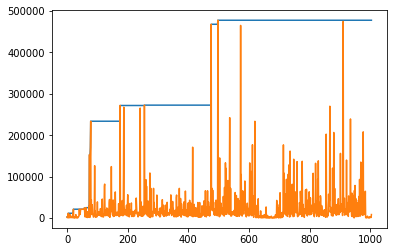

In [25]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
plt.show()

In [26]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_6S_Average.csv')

df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_6S_Average.csv')

### Check results with plot

In [20]:
inputs = [round(optimizer3.max['params']['IPTG1'], 2)+1e-7, int(optimizer3.max['params']['aTc1'])+1e-7, 
          round(optimizer3.max['params']['IPTG2'], 2)+1e-7, int(optimizer3.max['params']['aTc2'])+1e-7, 
          round(optimizer3.max['params']['IPTG3'], 2)+1e-7, int(optimizer3.max['params']['aTc3'])+1e-7, 
          round(optimizer3.max['params']['IPTG4'], 2)+1e-7, int(optimizer3.max['params']['aTc4'])+1e-7, 
          round(optimizer3.max['params']['IPTG5'], 2)+1e-7, int(optimizer3.max['params']['aTc5'])+1e-7, 
          round(optimizer3.max['params']['IPTG6'], 2)+1e-7, int(optimizer3.max['params']['aTc6'])+1e-7]

ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),7))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


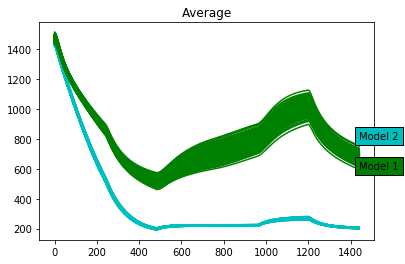

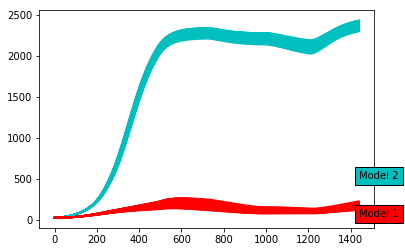

In [21]:
t = np.linspace(0,(24*60),round(24*60/5)+1)

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((24*60)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((24*60)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((24*60)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((24*60)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [ ]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [ ]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [ ]:
bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR+bdG)/2

In [ ]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The average BD is: ", str(u_B))